# Import libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create figures directory if it doesn't exist
os.makedirs('../../figures', exist_ok=True)

- what to do
    - give raphs for each learning rate
    - the change of regret?, total payoff, decisions?
    - horizontal axis must be the number of rounds
    - vertical axis must be one of them.

In [7]:
# Plotting helper used by multiple cells

def plot_learning_rate_comparison(results_dict, title, y_lim=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    # Regret over time
    for name, res in results_dict.items():
        axes[0].plot(res['regret_history'], label=name)
    axes[0].set_title('Regret over rounds')
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Regret')
    axes[0].legend()
    if y_lim is not None:
        axes[0].set_ylim(y_lim)
    # Total payoff (final)
    algos = list(results_dict.keys())
    totals = [res['total_payoff'] for res in results_dict.values()]
    axes[1].bar(range(len(algos)), totals)
    axes[1].set_title('Total payoff (final)')
    axes[1].set_ylabel('Total payoff')
    axes[1].set_xticks(range(len(algos)))
    axes[1].set_xticklabels(algos, rotation=20, ha='right')
    # Action selection frequency heatmap
    max_k = max(len(res['cumulative_payoffs']) for res in results_dict.values())
    freq_matrix = np.zeros((len(algos), max_k))
    for i, res in enumerate(results_dict.values()):
        counts = np.bincount(res['action_history'], minlength=max_k)
        freq_matrix[i, :] = counts / len(res['action_history'])
    im = axes[2].imshow(freq_matrix, aspect='auto', cmap='Blues', vmin=0, vmax=1)
    axes[2].set_title('Action selection frequency')
    axes[2].set_xlabel('Action')
    axes[2].set_yticks(range(len(algos)))
    axes[2].set_yticklabels(algos)
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


In [8]:
# Define variables and learning rates
k = 10  # actions
n = 1000  #  rounds

# Three learning rates to compare:
# 1. Random 
epsilon_random = 0

# 2. Theoretical optimal
epsilon_optimal = np.sqrt(np.log(k) / n)

# 3. FTL
epsilon_ftl = 1000

print(f"Number of actions (k): {k}")
print(f"Number of rounds (n): {n}")
print(f"Random epsilon: {epsilon_random:.6f}")
print(f"Theoretical optimal epsilon: {epsilon_optimal:.6f}")
print(f"FTL epsilon: {epsilon_ftl}")

Number of actions (k): 10
Number of rounds (n): 1000
Random epsilon: 0.000000
Theoretical optimal epsilon: 0.047985
FTL epsilon: 1000


In [9]:
# Exponential Weights Algorithm (numerically stable with log-weights)
class ExponentialWeights:
    # Three Parameters:
    
    def __init__(self, k, epsilon, n):
        self.k = k
        self.epsilon = epsilon
        self.n = n
        self.log_weights = np.zeros(k)  # use log-weights for numerical stability
        self.cumulative_payoffs = np.zeros(k)  # Track cumulative payoffs of each action
        self.regret_history = []  # Track regret over time
        self.total_payoff = 0  # Track our algorithm's total payoff
        self.action_history = []  # Track actions taken
        
    def select_action(self):
        """Select action based on current weights"""
        if self.epsilon == 0:
            # Random selection when epsilon is 0
            action = np.random.randint(0, self.k)
        else:
            # Stable softmax over log-weights
            max_log = np.max(self.log_weights)
            exps = np.exp(self.log_weights - max_log)
            sum_exps = np.sum(exps)
            if not np.isfinite(sum_exps) or sum_exps <= 0:
                # fallback to uniform if underflow/overflow
                action = np.random.randint(0, self.k)
            else:
                probabilities = exps / sum_exps
                # guard against any residual NaN
                if not np.all(np.isfinite(probabilities)):
                    action = np.random.randint(0, self.k)
                else:
                    action = np.random.choice(self.k, p=probabilities)
        
        self.action_history.append(action)
        return action
    
    def update_weights(self, payoffs):
        """
        Update weights based on received payoffs
        
        Parameters:
        - payoffs: array of payoffs for each action in this round
        """
        # Update cumulative payoffs of each action
        self.cumulative_payoffs += payoffs
        
        # Update our total payoff with payoff of selected action
        selected_action = self.action_history[-1]
        self.total_payoff += payoffs[selected_action]
        
        # Update log-weights: log w_i += epsilon * payoff_i
        if self.epsilon > 0:
            self.log_weights += self.epsilon * payoffs
        
        # Calculate regret to the best fixed action in hindsight
        best_fixed_cumulative = np.max(self.cumulative_payoffs)
        regret = best_fixed_cumulative - self.total_payoff
        self.regret_history.append(regret)
    
    def run_algorithm(self, payoff_generator):
        """
        Run the algorithm for n rounds
        
        Parameters:
        - payoff_generator: function that generates payoffs for each round
        """
        for round_num in range(self.n):
            # Select action
            action = self.select_action()
            
            # Generate payoffs for this round
            payoffs = payoff_generator(round_num)
            
            # Update weights and regret
            self.update_weights(payoffs)
        
        return {
            'regret_history': self.regret_history,
            'total_payoff': self.total_payoff,
            'action_history': self.action_history,
            'cumulative_payoffs': self.cumulative_payoffs
        }

# A. Adversarial Fair Payoffs

Testing Adversarial Fair Payoffs Model...


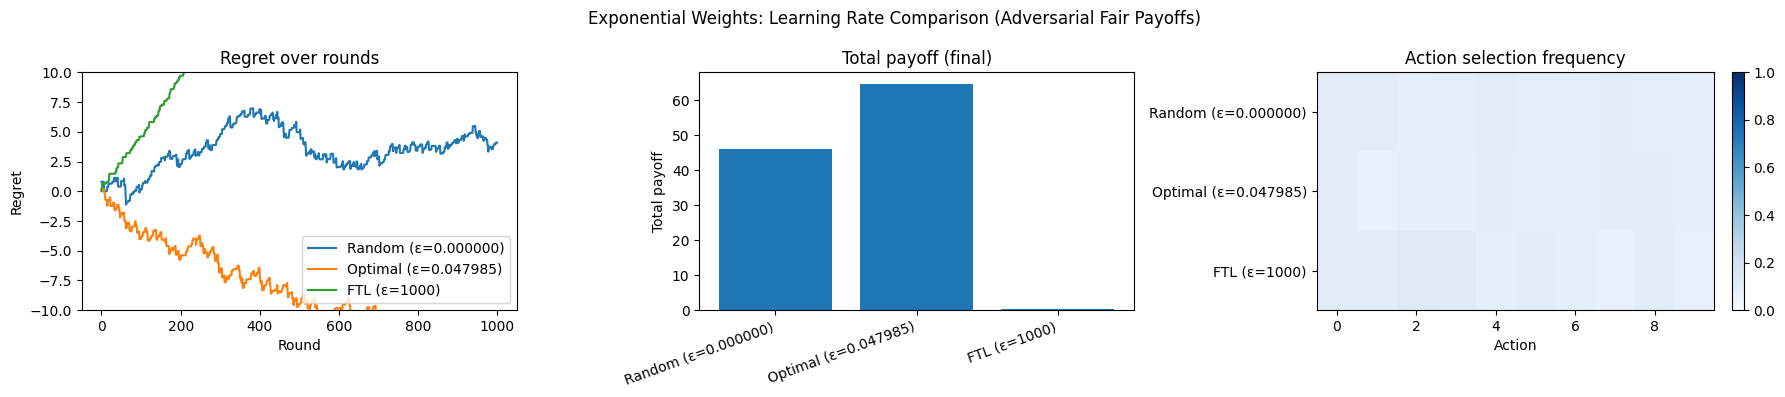


Adversarial Fair Payoffs - Summary Statistics:
--------------------------------------------------
Random (ε=0.000000):
  Final Regret: 4.0902
  Total Payoff: 46.1351
  Best Action: Action 8

Optimal (ε=0.047985):
  Final Regret: -12.7321
  Total Payoff: 64.7990
  Best Action: Action 1

FTL (ε=1000):
  Final Regret: 47.8162
  Total Payoff: 0.2179
  Best Action: Action 4



In [10]:
# A. Adversarial Fair Payoffs Implementation
class AdversarialFairPayoffs:
    """
    Adversarial Fair Payoffs model:
    - In each round, draw a payoff x ~ U[0,1]
    - Assign this payoff to the action with smallest total payoff so far
    - All other actions get 0 payoff
    """
    
    def __init__(self, k):
        self.k = k
        self.cumulative_payoffs = np.zeros(k)
    
    def generate_payoffs(self, round_num):
        """
        Generate payoffs for a given round
        
        Returns:
        - payoffs: array of payoffs for each action
        """
        # Draw a random payoff from uniform distribution [0,1]
        payoff = np.random.uniform(0, 1)
        
        # Find the action with smallest cumulative payoff
        min_action = np.argmin(self.cumulative_payoffs)
        
        # Create payoff vector: only the min action gets the payoff, others get 0
        payoffs = np.zeros(self.k)
        payoffs[min_action] = payoff
        
        # Update cumulative payoffs
        self.cumulative_payoffs += payoffs
        
        return payoffs

# Test Adversarial Fair Payoffs
print("Testing Adversarial Fair Payoffs Model...")
print("=" * 50)

# Test with different learning rates (fresh generator per run)
ew_random_adv = ExponentialWeights(k, epsilon_random, n)
ew_optimal_adv = ExponentialWeights(k, epsilon_optimal, n)
ew_ftl_adv = ExponentialWeights(k, epsilon_ftl, n)

# Run algorithms with independent generators
results_random_adv = ew_random_adv.run_algorithm(AdversarialFairPayoffs(k).generate_payoffs)
results_optimal_adv = ew_optimal_adv.run_algorithm(AdversarialFairPayoffs(k).generate_payoffs)
results_ftl_adv = ew_ftl_adv.run_algorithm(AdversarialFairPayoffs(k).generate_payoffs)

# Create results dictionary for adversarial payoffs
results_dict_adv = {
    f'Random (ε={epsilon_random:.6f})': results_random_adv,
    f'Optimal (ε={epsilon_optimal:.6f})': results_optimal_adv,
    f'FTL (ε={epsilon_ftl})': results_ftl_adv
}

# Plot comparison for adversarial payoffs (zoom y-axis around 0)
plot_learning_rate_comparison(results_dict_adv, "Exponential Weights: Learning Rate Comparison (Adversarial Fair Payoffs)", y_lim=(-10, 10))

# Print summary statistics for adversarial payoffs
print("\nAdversarial Fair Payoffs - Summary Statistics:")
print("-" * 50)
for name, results in results_dict_adv.items():
    final_regret = results['regret_history'][-1]
    total_payoff = results['total_payoff']
    print(f"{name}:")
    print(f"  Final Regret: {final_regret:.4f}")
    print(f"  Total Payoff: {total_payoff:.4f}")
    print(f"  Best Action: Action {np.argmax(results['cumulative_payoffs'])}")
    print()


# B. Bernoulli Payoffs Implementation


Testing Bernoulli Payoffs Model...
Bernoulli probabilities for each action: [0.1747614  0.15786056 0.39568146 0.34028033 0.14977816 0.22887191
 0.04777955 0.44907322 0.46771241 0.48990177]


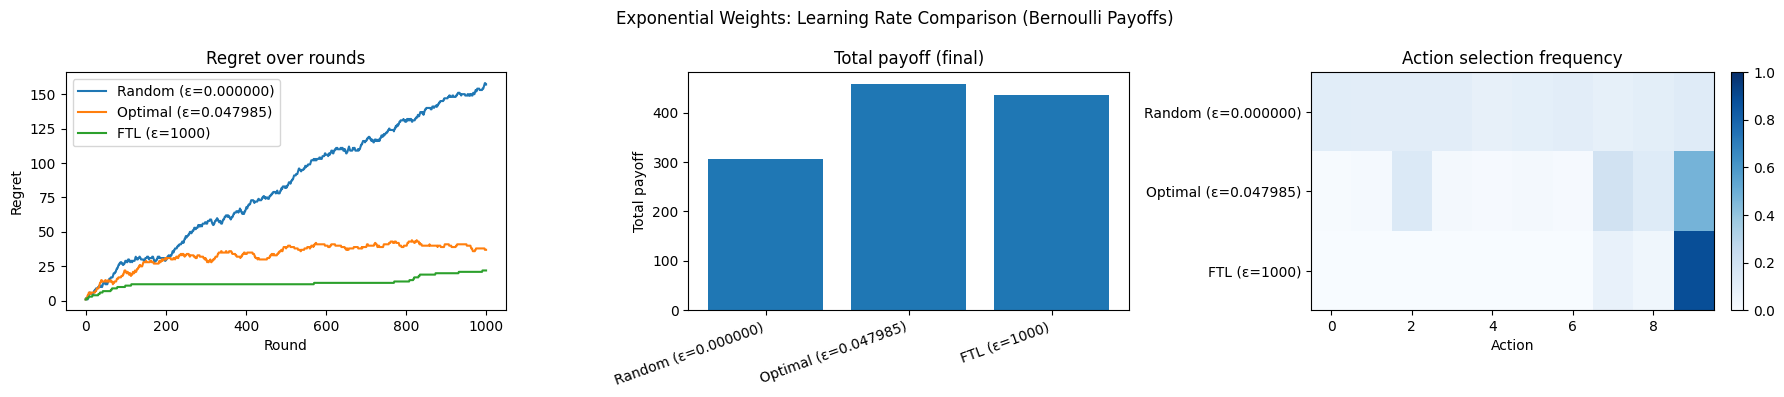


Bernoulli Payoffs - Summary Statistics:
--------------------------------------------------
Random (ε=0.000000):
  Final Regret: 157.0000
  Total Payoff: 306.0000
  Best Action: Action 7

Optimal (ε=0.047985):
  Final Regret: 37.0000
  Total Payoff: 459.0000
  Best Action: Action 9

FTL (ε=1000):
  Final Regret: 22.0000
  Total Payoff: 436.0000
  Best Action: Action 9

True Bernoulli probabilities for each action:
  Action 0: 0.1748
  Action 1: 0.1579
  Action 2: 0.3957
  Action 3: 0.3403
  Action 4: 0.1498
  Action 5: 0.2289
  Action 6: 0.0478
  Action 7: 0.4491
  Action 8: 0.4677
  Action 9: 0.4899
Best action (highest probability): Action 9


In [11]:
class BernoulliPayoffs:
    """
    Bernoulli Payoffs model:
    - Fix a probability p_j for each action j with p_j in [0, 1/2]
    - In each round, draw payoff for each action j as v_j ~ B(p_j)
    """
    
    def __init__(self, k):
        self.k = k
        # Generate probabilities for each action (all in [0, 1/2])
        self.probabilities = np.random.uniform(0, 0.5, k)
        print(f"Bernoulli probabilities for each action: {self.probabilities}")
    
    def generate_payoffs(self, round_num):
        """
        Generate payoffs for a given round
        
        Returns:
        - payoffs: array of payoffs for each action (0 or 1)
        """
        # Generate Bernoulli payoffs for each action
        payoffs = np.random.binomial(1, self.probabilities)
        return payoffs

# Test Bernoulli Payoffs
print("\nTesting Bernoulli Payoffs Model...")
print("=" * 50)

# Create payoff generator
bernoulli_generator = BernoulliPayoffs(k)

# Test with different learning rates
ew_random_bern = ExponentialWeights(k, epsilon_random, n)
ew_optimal_bern = ExponentialWeights(k, epsilon_optimal, n)
ew_ftl_bern = ExponentialWeights(k, epsilon_ftl, n)

# Run algorithms
results_random_bern = ew_random_bern.run_algorithm(bernoulli_generator.generate_payoffs)
results_optimal_bern = ew_optimal_bern.run_algorithm(bernoulli_generator.generate_payoffs)
results_ftl_bern = ew_ftl_bern.run_algorithm(bernoulli_generator.generate_payoffs)

# Create results dictionary for Bernoulli payoffs
results_dict_bern = {
    f'Random (ε={epsilon_random:.6f})': results_random_bern,
    f'Optimal (ε={epsilon_optimal:.6f})': results_optimal_bern,
    f'FTL (ε={epsilon_ftl})': results_ftl_bern
}

# Plot comparison for Bernoulli payoffs
plot_learning_rate_comparison(results_dict_bern, "Exponential Weights: Learning Rate Comparison (Bernoulli Payoffs)")

# Print summary statistics for Bernoulli payoffs
print("\nBernoulli Payoffs - Summary Statistics:")
print("-" * 50)
for name, results in results_dict_bern.items():
    final_regret = results['regret_history'][-1]
    total_payoff = results['total_payoff']
    print(f"{name}:")
    print(f"  Final Regret: {final_regret:.4f}")
    print(f"  Total Payoff: {total_payoff:.4f}")
    print(f"  Best Action: Action {np.argmax(results['cumulative_payoffs'])}")
    print()

# Show the true probabilities for reference
print("True Bernoulli probabilities for each action:")
for i, prob in enumerate(bernoulli_generator.probabilities):
    print(f"  Action {i}: {prob:.4f}")
print(f"Best action (highest probability): Action {np.argmax(bernoulli_generator.probabilities)}")

In [12]:
# Follow-The-Leader (FTL) policy and Monte Carlo helpers

class FollowTheLeader:
    def __init__(self, k, n):
        self.k = k
        self.n = n
        self.cumulative_payoffs = np.zeros(k)
        self.action_history = []
        self.total_payoff = 0
        self.regret_history = []

    def select_action(self):
        if len(self.action_history) == 0:
            return np.random.randint(0, self.k)
        # Break ties randomly among max cumulative payoff actions
        max_val = np.max(self.cumulative_payoffs)
        candidates = np.where(self.cumulative_payoffs == max_val)[0]
        return np.random.choice(candidates)

    def run_algorithm(self, payoff_generator):
        for t in range(self.n):
            a = self.select_action()
            self.action_history.append(a)
            payoffs = payoff_generator(t)
            self.cumulative_payoffs += payoffs
            self.total_payoff += payoffs[a]
            best_fixed = np.max(self.cumulative_payoffs)
            self.regret_history.append(best_fixed - self.total_payoff)
        return {
            'regret_history': self.regret_history,
            'total_payoff': self.total_payoff,
            'action_history': self.action_history,
            'cumulative_payoffs': self.cumulative_payoffs
        }


def run_monte_carlo(payoff_model_cls, k, n, epsilons, trials=50, model_name=""):
    all_histories = {f"ε={eps}": [] for eps in epsilons}
    all_histories["FTL"] = []
    for _ in range(trials):
        model = payoff_model_cls(k)
        # EW variants
        for eps in epsilons:
            ew = ExponentialWeights(k, eps, n)
            res = ew.run_algorithm(model.generate_payoffs)
            all_histories[f"ε={eps}"] .append(res['regret_history'])
        # FTL
        model_ftl = payoff_model_cls(k)
        ftl = FollowTheLeader(k, n)
        res_ftl = ftl.run_algorithm(model_ftl.generate_payoffs)
        all_histories["FTL"].append(res_ftl['regret_history'])
    # Aggregate mean and std
    mean_std = {}
    for name, histories in all_histories.items():
        arr = np.array(histories)
        mean_std[name] = {
            'mean': np.mean(arr, axis=0),
            'std': np.std(arr, axis=0)
        }
    return mean_std


def plot_monte_carlo_regret(mean_std, title, save_path=None, y_lim=None):
    plt.figure(figsize=(10, 5))
    for name, stats_obj in mean_std.items():
        mean = stats_obj['mean']
        std = stats_obj['std']
        x = np.arange(len(mean))
        plt.plot(x, mean, label=name)
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.xlabel('Round')
    plt.ylabel('Regret (mean ± std)')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


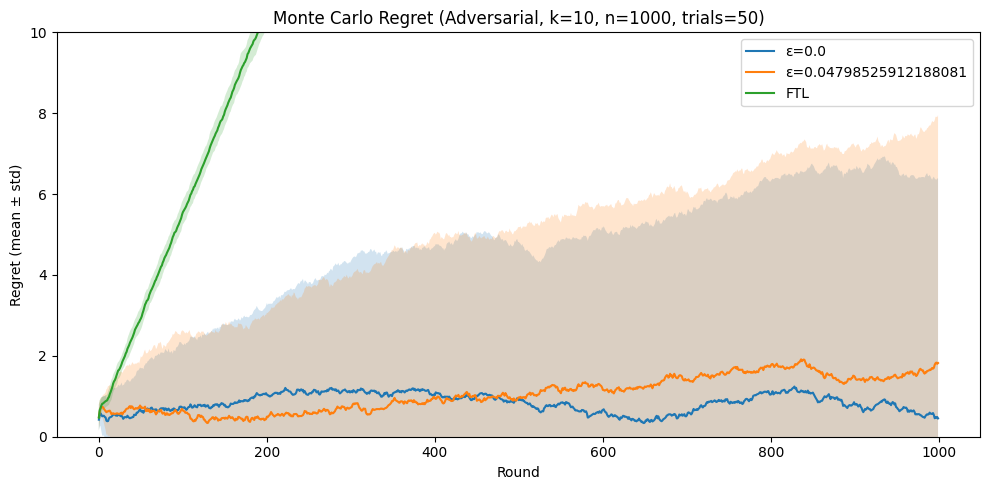

In [13]:
# Monte Carlo experiments: Adversarial Fair Payoffs

# Ensure parameters
try:
    _ = k; _ = n
except NameError:
    k = 10
    n = 1000

mc_epsilons = [0.0, float(np.sqrt(np.log(k) / n))]  # include a larger eps for contrast
mean_std_adv = run_monte_carlo(AdversarialFairPayoffs, k, n, mc_epsilons, trials=50, model_name="Adversarial")
plot_monte_carlo_regret(mean_std_adv, f"Monte Carlo Regret (Adversarial, k={k}, n={n}, trials=50)", save_path='../../figures/adv_mc_regret.png', y_lim=(0, 10))


Bernoulli probabilities for each action: [0.43331076 0.07896389 0.45107292 0.23429387 0.08890724 0.23126105
 0.05519333 0.18525911 0.25158905 0.24696563]
Bernoulli probabilities for each action: [0.28526137 0.25309501 0.29313147 0.32282069 0.40212994 0.48458687
 0.36090546 0.06643227 0.32023899 0.4032008 ]
Bernoulli probabilities for each action: [0.45690683 0.2151371  0.07647803 0.43060203 0.1517236  0.49859493
 0.25539767 0.38158025 0.18123892 0.42223293]
Bernoulli probabilities for each action: [0.37913934 0.30444294 0.33485961 0.21264838 0.13959153 0.18792141
 0.30774999 0.06853059 0.25623165 0.22302322]
Bernoulli probabilities for each action: [0.20443087 0.25476586 0.01523045 0.16761405 0.16347443 0.03502924
 0.34305385 0.35943189 0.03918316 0.33839765]
Bernoulli probabilities for each action: [0.14509515 0.49725893 0.14976748 0.04246411 0.45430271 0.14457834
 0.27025297 0.12243526 0.20192829 0.22414277]
Bernoulli probabilities for each action: [0.31341176 0.30934803 0.14985142 0

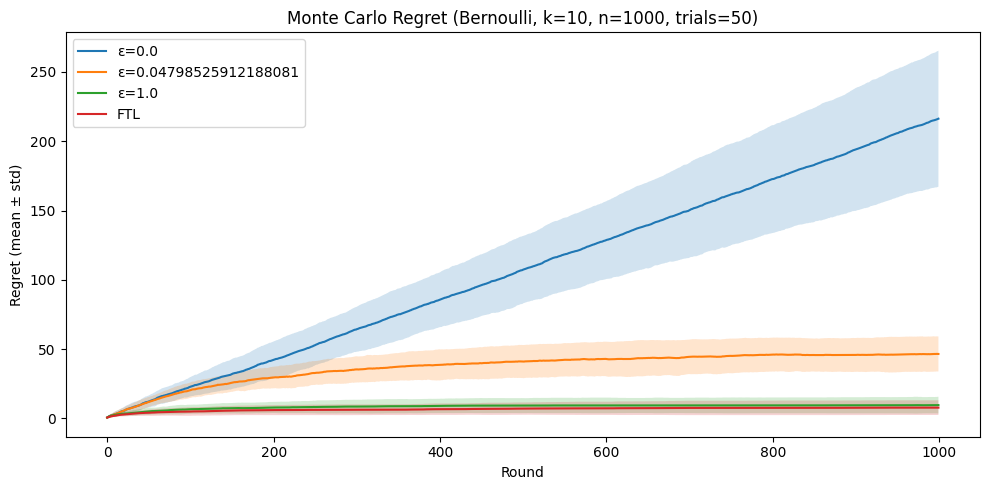

In [14]:
# Monte Carlo experiments: Bernoulli Payoffs

# Ensure parameters
try:
    _ = k; _ = n
except NameError:
    k = 10
    n = 1000

mc_epsilons = [0.0, float(np.sqrt(np.log(k) / n)), 1.0]
mean_std_bern = run_monte_carlo(BernoulliPayoffs, k, n, mc_epsilons, trials=50, model_name="Bernoulli")
plot_monte_carlo_regret(mean_std_bern, f"Monte Carlo Regret (Bernoulli, k={k}, n={n}, trials=50)", save_path='../../figures/bern_mc_regret.png')


# C. Data in the wild

# D. Adversarial generative model